In [21]:
from math import sqrt
import matplotlib.pyplot as plt
import torch
from torchfem import Tria1
from torchfem.io import import_mesh

from global_constants import EPS0, LBD, MU, B0, L, R, RATIO

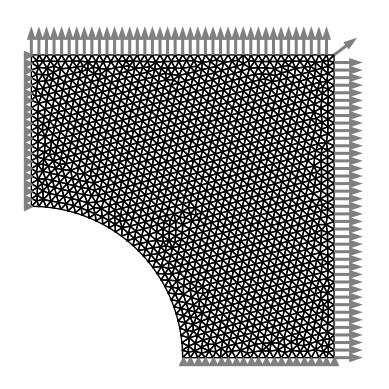

In [22]:
E = MU*(3.0*LBD+2*MU)/(LBD*MU)
nu = LBD/(2.0*(LBD+MU))
C = (E / ((1.0 + nu) * (1.0 - 2.0 * nu))) * torch.tensor(
    [[1.0 - nu, nu, 0.0], [nu, 1.0 - nu, 0.0], [0.0, 0.0, 0.5 - nu]]
)

# Import mesh
domain = import_mesh("mesh.vtk", C)

# Constrain left boundary
left = domain.nodes[:, 0] <= 0.001
domain.constraints[left, 0] = True

# Constrain bottom boundary
bottom = domain.nodes[:, 1] <= 0.001
domain.constraints[bottom, 1] = True

# Force at right boundary
right = domain.nodes[:, 0] == L 
domain.forces[right, 0] = 0.01
domain.forces[3, 0] = 0.005
domain.forces[4, 0] = 0.005

# Force at top boundary
top = domain.nodes[:, 1] == L 
domain.forces[top, 1] = 0.01 * RATIO
domain.forces[3, 1] = 0.005 * RATIO
domain.forces[2, 1] = 0.005 * RATIO

# Hole 
hole = (domain.nodes[:, 0]**2 + domain.nodes[:, 1]**2 - R**2 <= 0.001)
hole_idx = torch.argwhere(hole).ravel()
angles = torch.atan(domain.nodes[hole_idx, 1]/domain.nodes[hole_idx, 0])

# Plot the domain
domain.plot()
plt.show()

1.3703001737594604


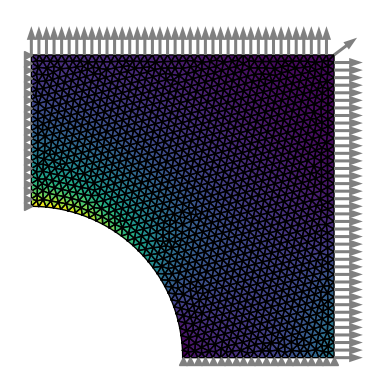

In [23]:
def mises_stress(u):
    s = domain.compute_stress(u)
    return torch.sqrt(s[...,0] ** 2 + s[...,1] ** 2 - s[..., 0] * s[..., 1] + 3 * s[...,2] ** 2)


# Plot the results
u, f = domain.solve()
domain.plot(element_property=mises_stress(u))
print(max(mises_stress(u)).item())

In [24]:
epsilon = 3.0
r = torch.cdist(domain.nodes, domain.nodes)
phi = torch.exp(-((epsilon * r) ** 2))
original_nodes = domain.nodes.clone()

def morph(nids, x, dir):
    # Build matrix
    M = phi[:, nids]
    M = M[nids, :]
    # Solve linear equation system
    weights = torch.linalg.solve(M, x - original_nodes[nids, dir])
    moved_nodes = original_nodes.clone()
    # Apply deformation
    for weight, node in zip(weights, nids):
        moved_nodes[:, dir] += weight * phi[node, :]
    domain.nodes[:, dir] = moved_nodes[:, dir]

In [25]:
def box_constrained_decent(func, x_init, x_lower, x_upper, eta=0.1, max_iter=100):
    x = x_init.clone().requires_grad_()
    for _ in range(max_iter):
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        x = x - eta * grad
        x = torch.max(torch.min(x, x_upper), x_lower)
    return x


def MMA(func, x_k, L_k, U_k):
    x_lin = x_k.clone().requires_grad_()
    grads = torch.autograd.grad(func(x_lin), x_lin)[0]
    f_k = func(x_k)

    def approximation(x):
        res = f_k * torch.ones_like(x[..., 0])
        for j, grad in enumerate(grads):
            if grad < 0.0:
                p = 0
                q = -((x_k[j] - L_k[j]) ** 2) * grad
            else:
                p = (U_k[j] - x_k[j]) ** 2 * grad
                q = 0
            res -= p / (U_k[j] - x_k[j]) + q / (x_k[j] - L_k[j])
            res += p / (U_k[j] - x[..., j]) + q / (x[..., j] - L_k[j])
        return res

    return approximation

In [26]:
def f(Rx):
    # Morph nodes
    Ry = R**2 / Rx
    # Update nodes
    morph(hole_idx, Rx*torch.cos(angles), 0)
    morph(hole_idx, Ry*torch.sin(angles), 1)
    # Solve fem with updated nodes
    u_k, f_k = domain.solve()
    # Compute stress
    stress = mises_stress(u_k)
    # Return top 5 stresses
    top5 = torch.topk(stress, 5)[0]
    return top5.sum()

In [27]:
def optimize(x_0, x_min, x_max, iter):
    s = 0.5

    # Set up lists for L, U, x
    L = []
    U = []
    x = [x_0]
    objective = []

    for k in range(iter):
        # Update asymptotes with heuristic procedure (see Exercise 04)
        if k > 1:
            L_k = torch.zeros_like(L[k - 1])
            U_k = torch.zeros_like(U[k - 1])
            for j in range(len(L_k)):
                if (x[k][j] - x[k - 1][j]) * (x[k - 1][j] - x[k - 2][j]) < 0.0:
                    L_k[j] = x[k][j] - s * (x[k - 1][j] - L[k - 1][j])
                    U_k[j] = x[k][j] + s * (U[k - 1][j] - x[k - 1][j])
                else:
                    L_k[j] = x[k][j] - 1.0 / sqrt(s) * (x[k - 1][j] - L[k - 1][j])
                    U_k[j] = x[k][j] + 1.0 / sqrt(s) * (U[k - 1][j] - x[k - 1][j])
            L.append(L_k)
            U.append(U_k)
        else:
            L.append(x[k] - s * (x_max - x_min))
            U.append(x[k] + s * (x_max - x_min))

        # Compute lower move limit in this step
        x_min_k = torch.maximum(x_min, 0.9 * L[k] + 0.1 * x[k])
        x_max_k = torch.minimum(x_max, 0.9 * U[k] + 0.1 * x[k])

        # Compute the current approximation function and save gradients
        f_tilde = MMA(f, x[k], L[k], U[k])

        # Compute the maximum of the dual function
        x_star = box_constrained_decent(f_tilde, x_0, x_min_k, x_max_k, eta=0.1)

        # Compute current optimal point with dual solution
        x.append(x_star)
        objective.append(f(x_star).detach())

    return x, objective

In [28]:
# Bounds on variables
x_0 = torch.tensor([0.5])
x_min = torch.tensor([0.4])
x_max = torch.tensor([0.6])

x_opt, f_opt = optimize(x_0, x_min, x_max, 15)

0.963428258895874
0.5689396262168884


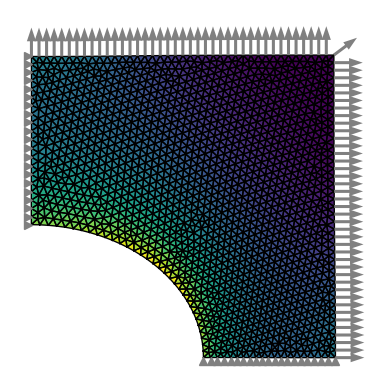

In [29]:
u, f = domain.solve()
stress = mises_stress(u)

domain.plot(element_property=stress)
print(max(mises_stress(u)).item())
print(x_opt[-1].item())